# Food Classification

## Classifying foods, training a model on Food-101

In [1]:
import os
from shutil import copy
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import keras
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.models import Model, load_model
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

print('done')

done


Using TensorFlow backend.


# Load Data and Create Splits
#### The data should be loaded in and split into train/validation sets

In [10]:
from collections import defaultdict
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')
    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")
    
    
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

# Display Some Images of Food
#### See what the foods look like for each label

In [4]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
    
print(class_to_ix)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

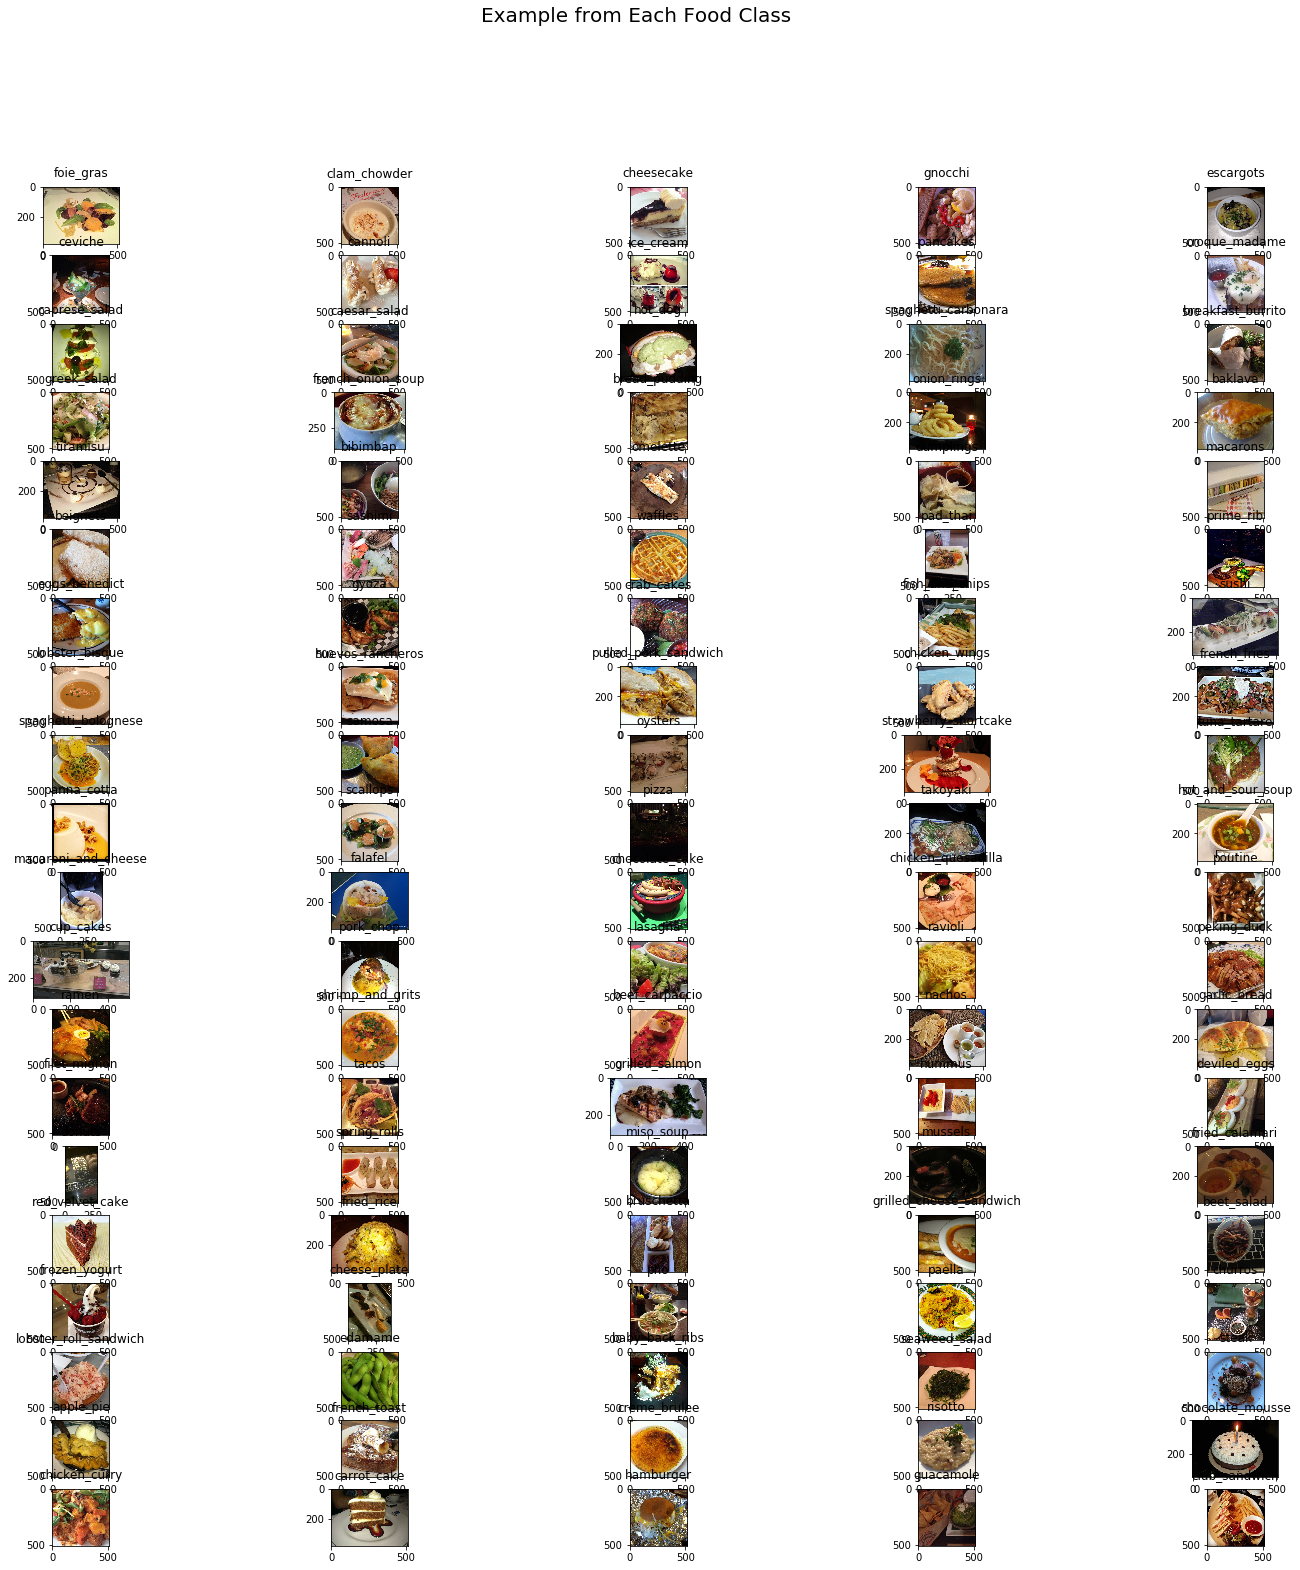

In [3]:
def display_images(path):
    rows = 20
    cols = 5
    food_folders = os.listdir(path)
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(25, 25))
    fig.suptitle('Example from Each Food Class', fontsize=20)
    for i in range(rows):
        for j in range(cols):
            try:
                selected_food_folder = food_folders[i*cols + j]
            except:
                break
            random_img = np.random.choice(os.listdir(os.path.join(path,selected_food_folder)))
            
            random_food_img = os.path.join(path, selected_food_folder, random_img)
            ax[i][j].imshow(plt.imread(random_food_img))
            ax[i][j].set_title(selected_food_folder, pad = 10)
    
display_images('food-101/train')
            

# Test and Train on Small Batch of Foods

In [11]:
import random
def pick_n_random_classes(n):
    food_list = []
    random_food_indices = random.sample(range(101),n) # We are picking n random food classes
    for i in random_food_indices:
        food_list.append(ix_to_class[i])
    food_list.sort()
    print("These are the randomly picked food classes we will be training the model on...\n", food_list)
    return food_list

food_list = pick_n_random_classes(12)


These are the randomly picked food classes we will be training the model on...
 ['baby_back_ribs', 'churros', 'cup_cakes', 'edamame', 'grilled_salmon', 'pancakes', 'ravioli', 'shrimp_and_grits', 'spring_rolls', 'steak', 'tuna_tartare', 'waffles']


In [12]:
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
    if os.path.exists(dest):
        rmtree(dest)
    os.makedirs(dest)
    for food_item in food_list :
        print("Copying images into",food_item)
        copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [13]:
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

dataset_mini(food_list, src_train, dest_train)
dataset_mini(food_list, src_test, dest_test)

Copying images into baby_back_ribs
Copying images into churros
Copying images into cup_cakes
Copying images into edamame
Copying images into grilled_salmon
Copying images into pancakes
Copying images into ravioli
Copying images into shrimp_and_grits
Copying images into spring_rolls
Copying images into steak
Copying images into tuna_tartare
Copying images into waffles
Copying images into baby_back_ribs
Copying images into churros
Copying images into cup_cakes
Copying images into edamame
Copying images into grilled_salmon
Copying images into pancakes
Copying images into ravioli
Copying images into shrimp_and_grits
Copying images into spring_rolls
Copying images into steak
Copying images into tuna_tartare
Copying images into waffles


In [15]:
print("Total number of samples in train folder")

!find food-101/train_mini -type d -or -type f -printf '.' | wc -c

print("Total number of samples in test folder")
!find food-101/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
9000
Total number of samples in test folder
3000


# Augment Images

In [3]:
def getAugmentedGenerators(train_path, val_path):
    train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(299, 299),
        batch_size=16,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        val_path,
        target_size = (299,299),
        batch_size=16,
        class_mode='categorical'
    )
    return train_generator, test_generator

In [19]:
mini_train_generator, mini_test_generator = getAugmentedGenerators('food-101/train_mini','food-101/test_mini')

Found 9000 images belonging to 12 classes.
Found 3000 images belonging to 12 classes.


# Create a Model with Base of InceptionV3

In [21]:
K.clear_session()
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(12, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Train Model on Mini Dataset

In [24]:
checkpoint = ModelCheckpoint(filepath='weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5',
                                       verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(mini_train_generator,
                    steps_per_epoch = 9000 // 16,
                    validation_data=mini_test_generator,
                    validation_steps=3000 // 16,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

Epoch 1/10
561/562 [============================>.] - ETA: 0s - loss: 1.5269 - accuracy: 0.5978
Epoch 00001: val_loss improved from inf to 0.98756, saving model to weights.epoch-01-val_loss-0.99.hdf5
562/562 [==============================] - 514s 914ms/step - loss: 1.5265 - accuracy: 0.5978 - val_loss: 0.9876 - val_accuracy: 0.7637
Epoch 2/10
561/562 [============================>.] - ETA: 0s - loss: 1.1382 - accuracy: 0.6860
Epoch 00002: val_loss improved from 0.98756 to 0.72947, saving model to weights.epoch-02-val_loss-0.73.hdf5
562/562 [==============================] - 512s 910ms/step - loss: 1.1383 - accuracy: 0.6860 - val_loss: 0.7295 - val_accuracy: 0.8172
Epoch 3/10
561/562 [============================>.] - ETA: 0s - loss: 0.9533 - accuracy: 0.7344
Epoch 00003: val_loss improved from 0.72947 to 0.60307, saving model to weights.epoch-03-val_loss-0.60.hdf5
562/562 [==============================] - 514s 915ms/step - loss: 0.9540 - accuracy: 0.7341 - val_loss: 0.6031 - val_accu

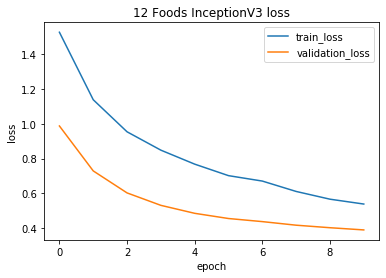

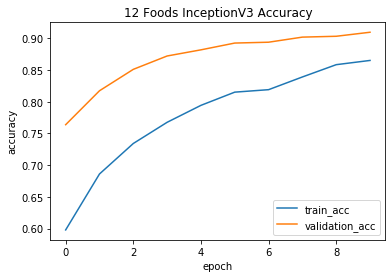

In [30]:
plt.title('12 Foods InceptionV3 loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

plt.title('12 Foods InceptionV3 Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validation_acc'], loc='best')
plt.show()

# Predictions!
#### Load Trained Food Inception Model and Download an Image For Predictions

In [36]:
def predict(model, food_list, images):
    for img in images:
        img = load_img(img, target_size = (299,299))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img /= 255.
        img_pred = model.predict(img)
        top_pred = np.argmax(img_pred, axis=1)[0]
        #top_n_preds= np.argpartition(y_pred, -3)[:,-3:]
        print(str(round(max(img_pred)[top_pred] * 100, 2)) + '% probability')
        food = food_list[top_pred]
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(food)
        plt.show()

In [42]:
!wget -O edamame.jpg https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/280/280285/a-bowl-of-edamame-that-has-many-health-benefits.jpg?w=1155&h=1444
!wget -O ribs.jpg https://www.traegergrills.com.au/on/demandware.static/-/Library-Sites-TraegerSharedLibrary/default/dw19e84bf8/images/recipes/20180913_3-2-1-Baby-Back-Ribs_RE_HE_M.jpg

--2020-02-18 22:37:24--  https://www.traegergrills.com.au/on/demandware.static/-/Library-Sites-TraegerSharedLibrary/default/dw19e84bf8/images/recipes/20180913_3-2-1-Baby-Back-Ribs_RE_HE_M.jpg
Resolving www.traegergrills.com.au (www.traegergrills.com.au)... 104.17.121.188, 104.17.120.188
Connecting to www.traegergrills.com.au (www.traegergrills.com.au)|104.17.121.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206719 (202K) [image/jpeg]
Saving to: 'ribs.jpg'

ribs.jpg            100%[===================>] 201.87K  --.-KB/s    in 0.02s   

2020-02-18 22:37:24 (10.1 MB/s) - 'ribs.jpg' saved [206719/206719]



In [40]:
K.clear_session()
best_model = tf.keras.models.load_model('./weights.epoch-10-val_loss-0.39.hdf5', compile=False)
print(food_list)


['baby_back_ribs', 'churros', 'cup_cakes', 'edamame', 'grilled_salmon', 'pancakes', 'ravioli', 'shrimp_and_grits', 'spring_rolls', 'steak', 'tuna_tartare', 'waffles']


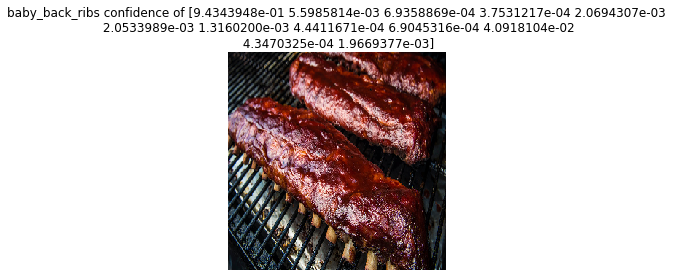

In [48]:
images = []
images.append('ribs.jpg')
predict(best_model, food_list, images)

# Train Model on Complete Dataset

In [3]:
K.clear_session()
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(101, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
train_generator, test_generator = getAugmentedGenerators('food-101/train','food-101/test')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [ ]:
checkpoint = ModelCheckpoint(filepath='saved-weights/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5',
                                       verbose=1, save_best_only=True)
csv_logger = CSVLogger('historyComplete.log')
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                    steps_per_epoch = 75750 // 16,
                    validation_data=test_generator,
                    validation_steps= 25250 // 16,
                    epochs=16,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

Epoch 1/16
 566/4734 [==>...........................] - ETA: 1:00:21 - loss: 5.1894 - accuracy: 0.0133

In [ ]:
K.clear_session()
curr_model = tf.keras.models.load_model('saved-weights/weights.epoch-16-val_loss-0.93.hdf5')
checkpoint = ModelCheckpoint(filepath='saved-weights/weights2.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5',
                                       verbose=1, save_best_only=True)
csv_logger = CSVLogger('historyComplete2.log')
curr_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = curr_model.fit_generator(train_generator,
                    steps_per_epoch = 75750 // 16,
                    validation_data=test_generator,
                    validation_steps= 25250 // 16,
                    epochs=16,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

Epoch 1/16
 311/4734 [>.............................] - ETA: 1:04:25 - loss: 1.0603 - accuracy: 0.7952

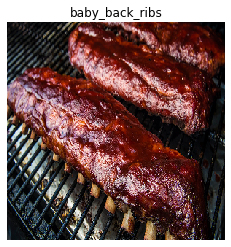

In [8]:
K.clear_session()
complete_model = tf.keras.models.load_model('saved-weights/weights2.epoch-13-val_loss-0.82.hdf5', compile=False)
images = []
images.append('ribs.jpg')
predict(complete_model, ix_to_class, images)

In [43]:
!wget -O pasta.jpg https://www.rachaelrayshow.com/sites/default/files/styles/video_1920x1080/public/images/2019-02/sweet_and_sour_and_smoky_-_red_onion_and_smoked_bacon_spaghetti_with_cherry_peppers_1920.jpg?itok=7M_1uZin

--2020-02-22 01:31:06--  https://www.rachaelrayshow.com/sites/default/files/styles/video_1920x1080/public/images/2019-02/sweet_and_sour_and_smoky_-_red_onion_and_smoked_bacon_spaghetti_with_cherry_peppers_1920.jpg?itok=7M_1uZin
Resolving www.rachaelrayshow.com (www.rachaelrayshow.com)... 151.101.53.188
Connecting to www.rachaelrayshow.com (www.rachaelrayshow.com)|151.101.53.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191456 (187K) [image/jpeg]
Saving to: 'pasta.jpg'

pasta.jpg           100%[===================>] 186.97K  --.-KB/s    in 0.03s   

2020-02-22 01:31:06 (6.70 MB/s) - 'pasta.jpg' saved [191456/191456]



# Predict on Complete 101 Foods

99.79% probability


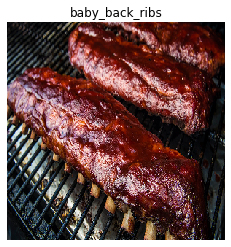

88.17% probability


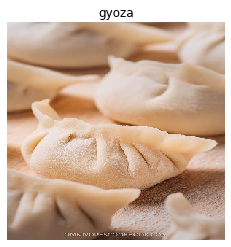

99.68% probability


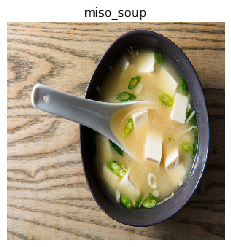

96.46% probability


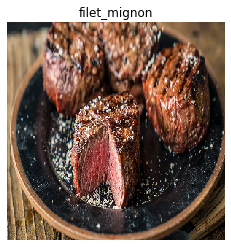

99.94% probability


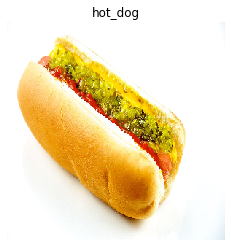

99.94% probability


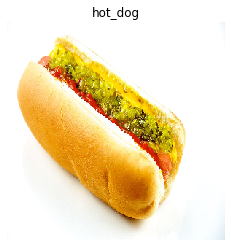

99.94% probability


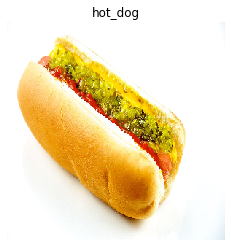

99.91% probability


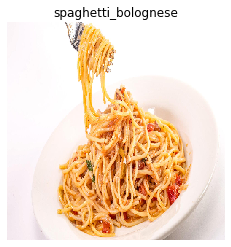

In [44]:
images.append('pasta.jpg')
predict(complete_model, ix_to_class, images)